# Serve Model

## Story
* We have a fully trained TensorFlow model
* TensorFlow models are ideal to bring them into production
* The model is stored as a computational graph and can be executed pretty much anywhere
  1. We can just load the saved model and exeute it from Python or
  1. There is a specific CC built server that can just serve it
  1. It will run in the Cloud as is
  1. Can be integrated into Java
* Even Docker can be made to have access to GPU

In [1]:
!ls -l classifier

total 248
drwxr-xr-x 2 olli olli   4096 Oct 24 17:34 assets
-rw-r--r-- 1 olli olli  15561 Oct 24 17:34 keras_metadata.pb
-rw-r--r-- 1 olli olli 227146 Oct 24 17:34 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Oct 24 17:34 variables


## Load and use model from Python

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
# https://www.tensorflow.org/guide/keras/save_and_serialize

reconstructed_model = tf.keras.models.load_model("classifier")
reconstructed_model

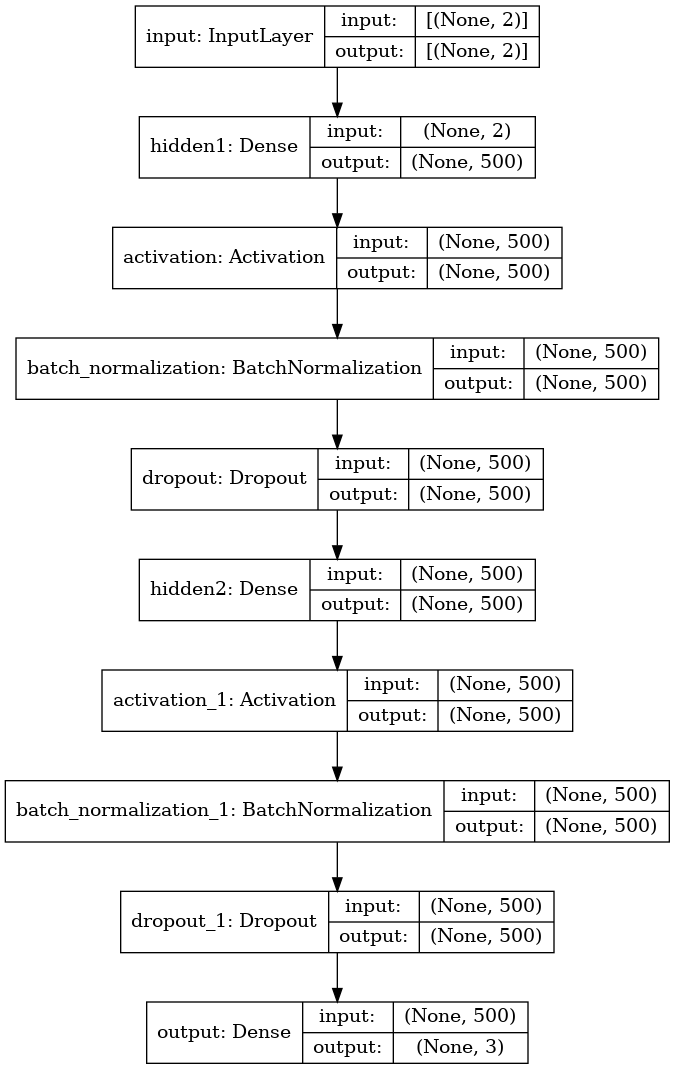

In [4]:
tf.keras.utils.plot_model(reconstructed_model, show_shapes=True)

In [28]:
%%time

reconstructed_model.predict([[48, 100]])

CPU times: user 60.8 ms, sys: 2.49 ms, total: 63.3 ms
Wall time: 54.3 ms


array([[0.02556643, 0.1980141 , 0.77641946]], dtype=float32)

In [17]:
reconstructed_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input) at 0x7F6CE43C13D0>})

In [18]:
inference_fn = reconstructed_model.signatures['serving_default']
inference_fn

<ConcreteFunction signature_wrapper(*, input) at 0x7F6CE43C13D0>

In [19]:
t = tf.convert_to_tensor([[48, 100]], dtype=tf.float32)
t

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 48., 100.]], dtype=float32)>

In [26]:
%%time

inference_fn(input=t)

CPU times: user 2.24 ms, sys: 898 µs, total: 3.14 ms
Wall time: 2.02 ms


{'output': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.02556643, 0.1980141 , 0.77641946]], dtype=float32)>}

In [11]:
# * https://www.tensorflow.org/guide/intro_to_graphs
# * https://www.tensorflow.org/api_docs/python/tf/Graph#as_graph_def 

# The serialized GraphDef can be imported into another Graph (using tf.import_graph_def) or used with the C++ Session API.

graph = inference_fn.graph.as_graph_def()
type(graph)

tensorflow.core.framework.graph_pb2.GraphDef

In [12]:
graph

node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "input"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 2
        }
      }
    }
  }
}
node {
  name: "unknown"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_0"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_2"
  op: "Placeholder"
  attr {
    key: "dtype"
    val

## Load and use model from C++ server

https://github.com/tensorflow/serving

In [15]:
!saved_model_cli show --dir classifier --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/tfx/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/

In [19]:
!pwd

/home/olli/notebooks/mlops


In [28]:
!mkdir insurance

In [29]:
!cp -R classifier/ insurance/1

In [ ]:
!tensorflow_model_server --port=8500 --rest_api_port=8501 \
  --model_name=insurance --model_base_path=/home/olli/notebooks/mlops/insurance

2021-10-24 19:31:09.759197: I tensorflow_serving/model_servers/server.cc:89] Building single TensorFlow model file config:  model_name: insurance model_base_path: /home/olli/notebooks/mlops/insurance
2021-10-24 19:31:09.759398: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2021-10-24 19:31:09.759415: I tensorflow_serving/model_servers/server_core.cc:591]  (Re-)adding model: insurance
2021-10-24 19:31:09.860552: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: insurance version: 1}
2021-10-24 19:31:09.860611: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: insurance version: 1}
2021-10-24 19:31:09.860620: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: insurance version: 1}
2021-10-24 19:31:09.860653: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /home/olli/notebooks/mlops/insurance

In [31]:
!curl -d '{"instances": [[50.0, 122.0], [48, 100], [30, 150]]}' -X POST http://localhost:8501/v1/models/insurance:predict

curl: (7) Failed to connect to localhost port 8501: Connection refused


## Start using Docker

- TensorFlow with Docker: https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/docker.md
- TFX Serving: https://www.tensorflow.org/tfx/serving/docker
- Complete example: https://github.com/embarced/notebooks/tree/master/tfx
- GPU support: 
  - https://www.tensorflow.org/tfx/serving/docker#serving_with_docker_using_your_gpu
  - https://github.com/NVIDIA/nvidia-docker
    - https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#docker
  - https://docs.docker.com/compose/gpu-support/